# Прогнозирование открытие депозита. Решение задачи классификации

In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, LabelBinarizer
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

## 1. Знакомство с данными, обработка пропусков и выбросов

In [619]:
df = pd.read_csv('bank_fin.csv', sep = ';')

<b>Данные о клиентах банка:</b>

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

<b>Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:</b>

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

<b>Прочие признаки:</b>

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Её мы будем пытаться предсказать в данном кейсе.

In [621]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [622]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [623]:
df['balance'].isna().value_counts()

False    11137
True        25
Name: balance, dtype: int64

In [625]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [627]:
def make_convert(row):
    # функция для преобразования признака в вещественное число
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

In [628]:
df['balance'] = df['balance'].apply(make_convert)

In [629]:
print('Среднее значение баланса:', round(df['balance'].mean(), 3))

Среднее значение баланса: 1529.129


In [ ]:
# заменяем пропуски на медианное значение
df['balance'] = df['balance'].fillna(df['balance'].median())

In [632]:
print('Среднее значение баланса после замены отсутствующих значений:', round(df['balance'].mean(), 3))

Среднее значение баланса после замены отсутствующих значений: 1526.936


In [634]:
display(df['job'].mode())
display(df['education'].mode())

0    management
dtype: object

0    secondary
dtype: object

In [635]:
# обрабатываем пропуски в категориальных признаказ: job и education, заменив их на модальное значение
df['job'] = df['job'].replace(to_replace='unknown', value='management', regex=True)
df['education'] = df['education'].replace(to_replace='unknown', value='secondary', regex=True)

In [636]:
round(df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean(), 3)

1598.883

In [638]:
def outliers_iqr(data, feature):
    # функция для удаления признаков по квантилям
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    print(f'Нижняя граница поиска выбросов по методу Тьюки: {lower_bound}')
    upper_bound = quartile_3 + (iqr * 1.5)
    print(f'Верхняя граница поиска выбросов по методу Тьюки: {upper_bound}')
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [639]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница поиска выбросов по методу Тьюки: -2241.0
Верхняя граница поиска выбросов по методу Тьюки: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10104


In [640]:
df = df.drop(outliers.index, axis=0)

In [641]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## 2.  Разведывательный анализ

Text(0.5, 1.0, 'Распределение классов')

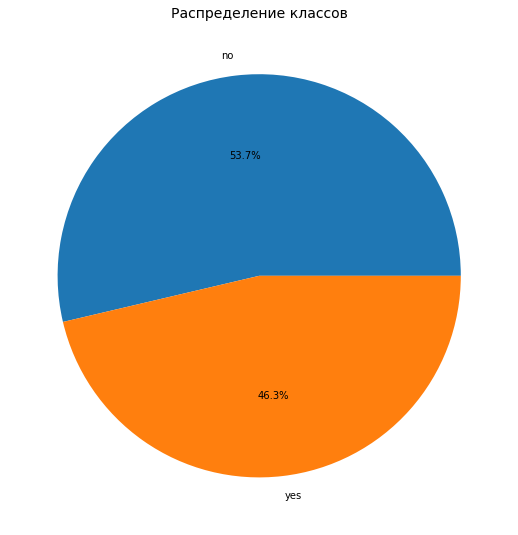

In [643]:
deposit_values = df['deposit'].value_counts()
fig = plt.figure(figsize=(7, 7))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    deposit_values,
    labels=deposit_values.index,
    autopct='%.1f%%'
)
plt.title("Распределение классов", fontsize=14)

In [644]:
display(deposit_values)

no     5424
yes    4681
Name: deposit, dtype: int64

In [646]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [648]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [650]:
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

In [652]:
month_deposit_no = df[df['deposit'] == 'no'].groupby('month')['deposit'].count()

month_deposit_no

month
apr     317
aug     775
dec       9
feb     323
jan     194
jul     836
jun     606
mar      24
may    1776
nov     456
oct      62
sep      46
Name: deposit, dtype: int64

In [653]:
month_deposit_no = df[df['deposit'] == 'no'].groupby(by=['month'], as_index=False)['deposit'].count()

month_deposit_no

,month,deposit
0,apr,317
1,aug,775
2,dec,9
3,feb,323
4,jan,194
5,jul,836
6,jun,606
7,mar,24
8,may,1776
9,nov,456


In [654]:
fig_age = px.histogram(
    data_frame = month_deposit_no,
    x = 'month',
    y = 'deposit',
    height = 500,
    width = 1000,
    title = 'Количество отказова от услуги в зависимости от месяца'
    )

fig_age.show()

In [656]:
# создаем возрастные группы

cut_labels = ['<30', '30-40', '40-50', '50-60', '60+']
cut_bins = [0, 30, 40, 50, 60, 100]

df['age_inter'] = pd.cut(df['age'], bins=cut_bins, labels=cut_labels)

In [657]:
deposit_age = df.groupby(['deposit', 'age_inter'], as_index=False)['deposit'].agg(['count']).reset_index()
deposit_age

,deposit,age_inter,count
0,no,<30,819
1,no,30-40,2215
2,no,40-50,1360
3,no,50-60,933
4,no,60+,97
5,yes,<30,1051
6,yes,30-40,1627
7,yes,40-50,895
8,yes,50-60,692
9,yes,60+,416


Text(0, 0.5, 'Возраст по группам')

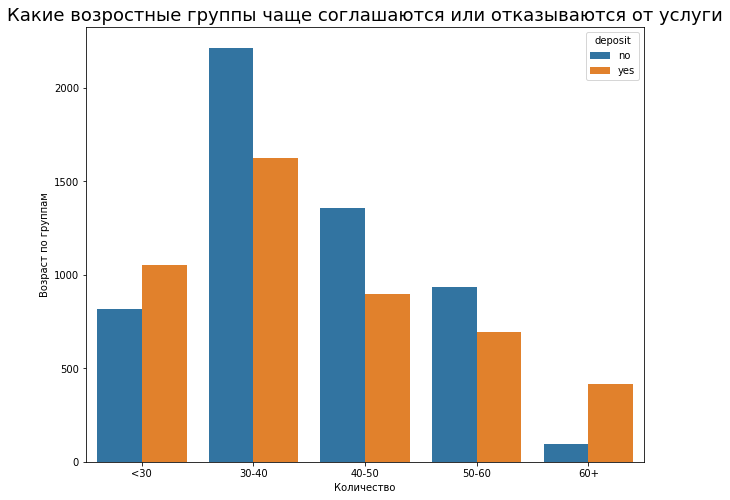

In [658]:
deposit_age['age_inter'] = deposit_age['age_inter'].astype(object)

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=deposit_age,
    x='age_inter',
    y='count',
    hue='deposit'
)

plt.title('Какие возростные группы чаще соглашаются или отказываются от услуги', fontsize=18)
plt.xlabel('Количество')
plt.ylabel('Возраст по группам')

In [660]:
marital_deposit = df.groupby(['deposit', 'marital'], as_index=False)['deposit'].agg(['count']).reset_index()
marital_deposit

,deposit,marital,count
0,no,divorced,624
1,no,married,3303
2,no,single,1497
3,yes,divorced,553
4,yes,married,2412
5,yes,single,1716


Text(0, 0.5, 'Количество')

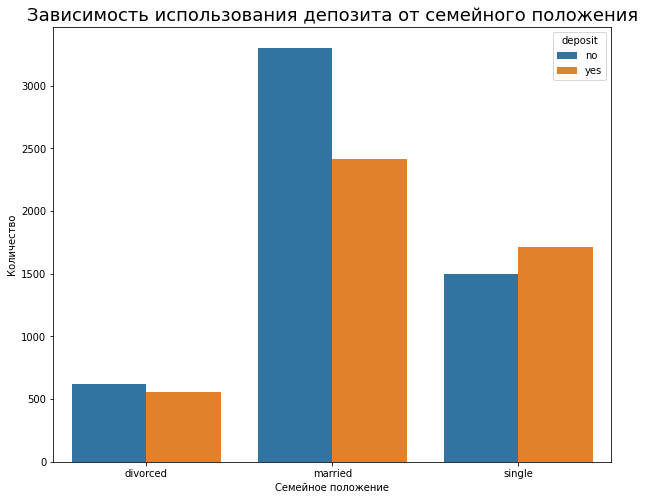

In [661]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=marital_deposit, 
    x='marital',
    y='count',
    hue='deposit'
)

plt.title('Зависимость использования депозита от семейного положения', fontsize=18)
plt.xlabel('Семейное положение')
plt.ylabel('Количество')

In [663]:
edu_deposit = df.groupby(['deposit', 'education'], as_index=False)['deposit'].agg(['count'])
edu_deposit

count
deposit education       
no      primary      832
        secondary   3066
        tertiary    1526
yes     primary      517
        secondary   2451
        tertiary    1713

Text(0, 0.5, 'Количество')

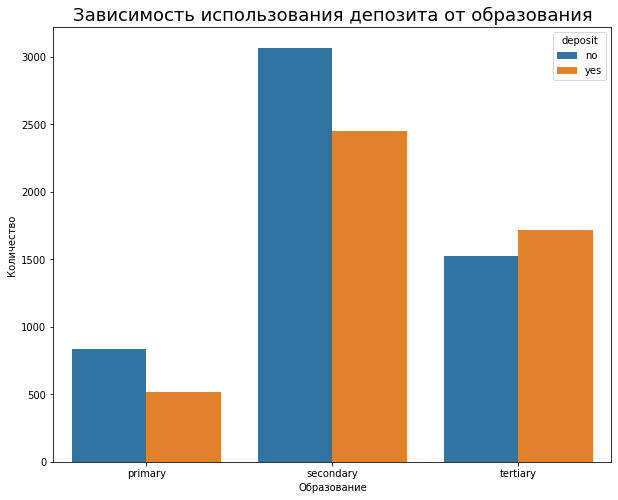

In [664]:
edu_deposit = edu_deposit.reset_index()

edu_deposit['education'] = edu_deposit['education'].astype(object)
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(
    data=edu_deposit, 
    x='education',
    y='count',
    hue='deposit'
)

plt.title('Зависимость использования депозита от образования', fontsize=18)
plt.xlabel('Образование')
plt.ylabel('Количество')

In [666]:
job_deposit = df.groupby(['deposit', 'job'], as_index=False)['deposit'].agg(['count'])
job_deposit

count
deposit job                 
no      admin.           672
        blue-collar     1155
        entrepreneur     189
        housemaid        153
        management      1180
        retired          231
        self-employed    197
        services         523
        student           81
        technician       900
        unemployed       143
yes     admin.           574
        blue-collar      652
        entrepreneur     111
        housemaid         99
        management      1135
        retired          432
        self-employed    161
        services         345
        student          245
        technician       738
        unemployed       189

Text(0, 0.5, 'Количество')

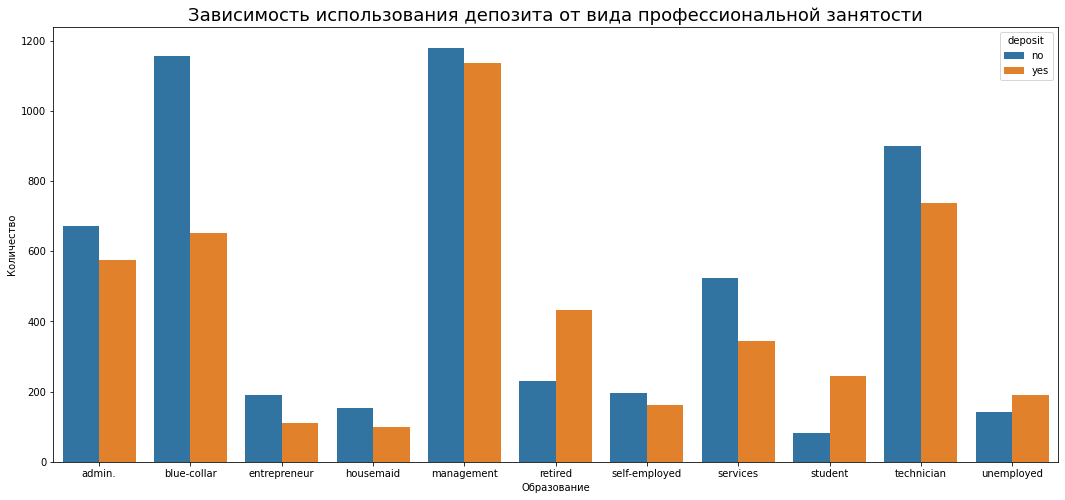

In [667]:
job_deposit = job_deposit.reset_index()

job_deposit['job'] = job_deposit['job'].astype(object)
fig, ax = plt.subplots(figsize=(18, 8))

sns.barplot(
    data=job_deposit, 
    x='job',
    y='count',
    hue='deposit'
)

plt.title('Зависимость использования депозита от вида профессиональной занятости', fontsize=18)
plt.xlabel('Образование')
plt.ylabel('Количество')

In [669]:
edu_fam_deposit = df[df['deposit'] == 'yes'].groupby(
    ['education', 'marital'], 
    as_index=False
)['deposit'].agg(['count']).reset_index()

edu_fam_deposit

,education,marital,count
0,primary,divorced,96
1,primary,married,339
2,primary,single,82
3,secondary,divorced,283
4,secondary,married,1289
5,secondary,single,879
6,tertiary,divorced,174
7,tertiary,married,784
8,tertiary,single,755


Text(0, 0.5, 'Количество')

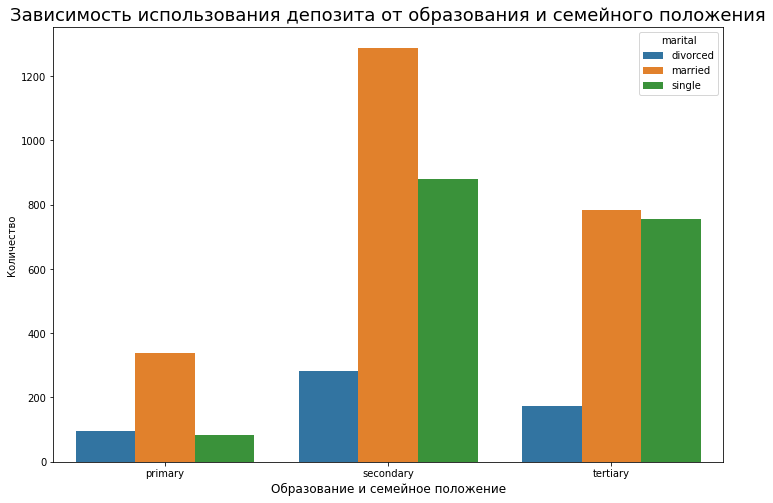

In [670]:
edu_fam_deposit['education'] = edu_fam_deposit['education'].astype(object)
edu_fam_deposit['marital'] = edu_fam_deposit['marital'].astype(object)
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=edu_fam_deposit, 
    x='education',
    y='count',
    hue='marital'
)

plt.title('Зависимость использования депозита от образования и семейного положения', fontsize=18)
plt.xlabel('Образование и семейное положение', fontsize=12)
plt.ylabel('Количество')

## 3. Преобразование данных

In [672]:
# преобразовываем уровни образования
le_edu = LabelEncoder()

le_edu.fit(df['education'])
df['education'] = le_edu.transform(df['education'])

In [673]:
print(df['education'].value_counts())
print(df['education'].sum())

1    5517
2    3239
0    1349
Name: education, dtype: int64
11995


In [674]:
le_edu.fit(df['age_inter'])
df['age'] = le_edu.transform(df['age_inter'])

In [675]:
df = df.drop(['age_inter'], axis=1)

In [676]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,2,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,2,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,1,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,2,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,2,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,0,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,0,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,1,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [678]:
# преобразовываем бинарные переменные в представление из нулей и единиц

lb = LabelBinarizer()

lb.fit(df['deposit'])
df['deposit'] = lb.transform(df['deposit'])

lb.fit(df['default'])
df['default'] = lb.transform(df['default'])

lb.fit(df['housing'])
df['housing'] = lb.transform(df['housing'])

lb.fit(df['loan'])
df['loan'] = lb.transform(df['loan'])

In [679]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,2,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,2,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,1,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1


In [680]:
df.describe()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,1.437308,1.187036,0.016428,807.653538,0.481148,0.137853,15.590302,368.742603,2.517170,51.319644,0.816230,0.463236
std,1.489490,0.647373,0.127119,994.151966,0.499669,0.344762,8.441510,346.651524,2.707159,109.644179,2.243795,0.498671
min,0.000000,0.000000,0.000000,-2049.000000,0.000000,0.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,95.000000,0.000000,0.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,445.000000,0.000000,0.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1227.000000,1.000000,0.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1.000000
max,4.000000,2.000000,1.000000,4063.000000,1.000000,1.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,1.000000


In [683]:
# создайте дамми-переменные
df_dummies = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df_dummies

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,2,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,1,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,2,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,2,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,0,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,0,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,1,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


In [684]:
df = df.merge(df_dummies, how='left')

In [685]:
df = df.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)
df

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,2,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,2,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,1,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,2,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,2,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,0,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
10101,0,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
10102,0,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
10103,1,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


<AxesSubplot:>

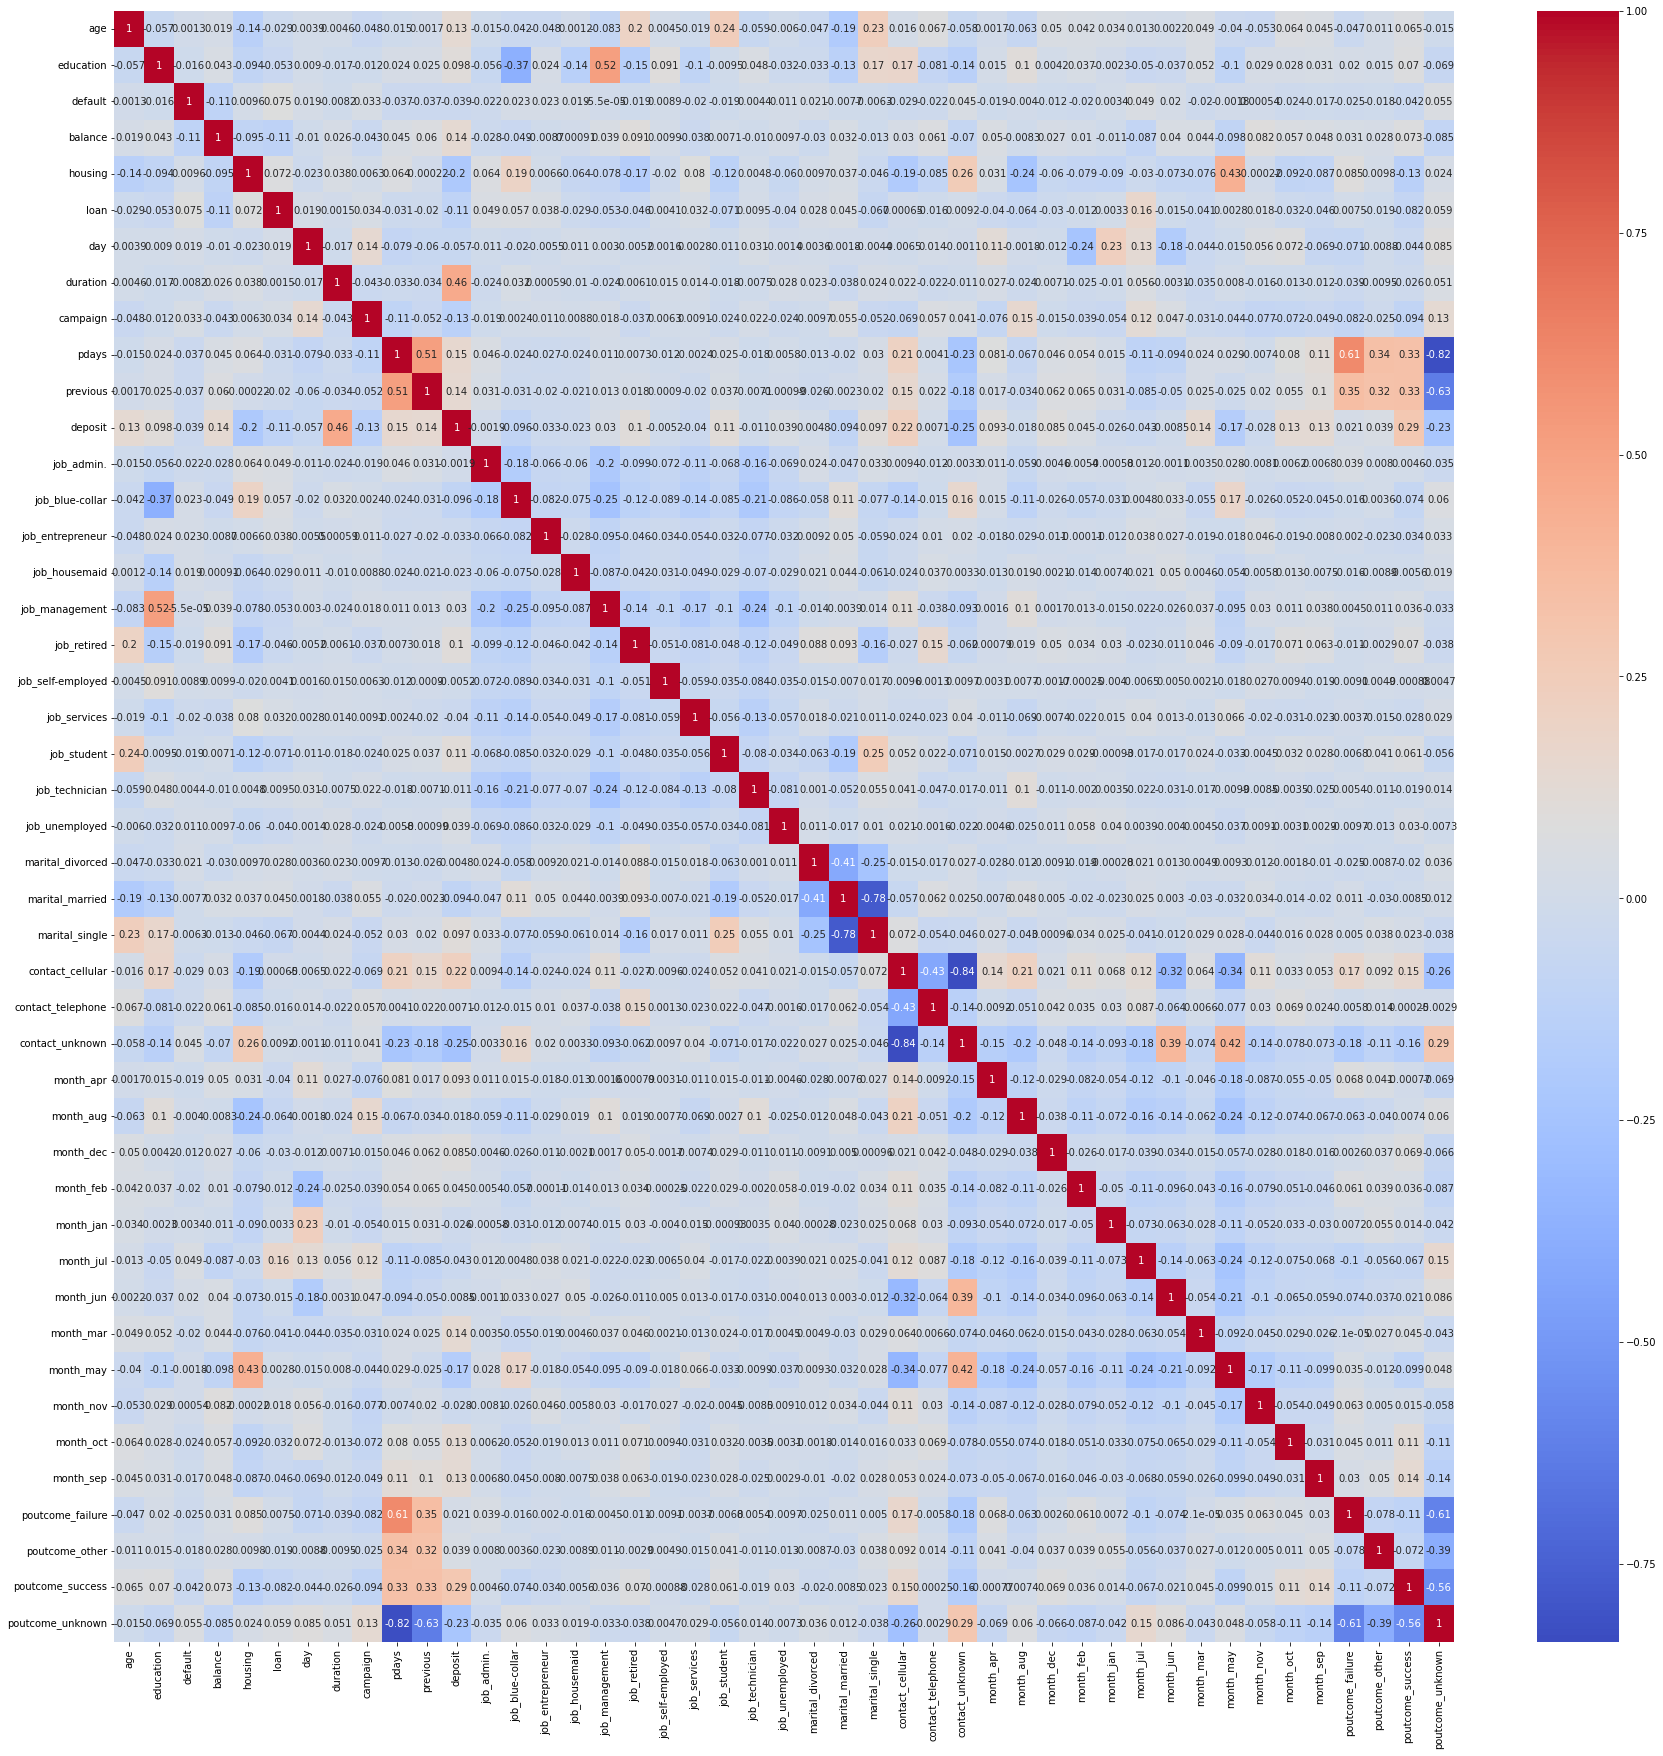

In [687]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [688]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [689]:
y_test

2933    1
5397    0
5043    0
2295    1
8102    0
       ..
1552    1
8743    0
7737    0
9930    0
3371    1
Name: deposit, Length: 3335, dtype: int64

In [694]:
# с помощью SelectKBest отбираем 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

selector.get_feature_names_out()

array(['age', 'balance', 'housing', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [695]:
X = df[['age', 'balance', 'housing', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]

y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [696]:
# нормализуем данные с помощью minmaxsxaler

In [697]:
col_names = list(X_train.columns)
col_names

['age',
 'balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [698]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [699]:
#df_mm = pd.DataFrame(df_mm, columns=col_names)

In [700]:
X_test_scaled[:, 1].mean()

0.46823674223097866

# 4. Решение задачи классификации: логистическая регрессия и решающие деревья

In [701]:
from sklearn import linear_model

In [702]:
# обучаем логистическую регрессию и рассчитываем метрики качества
lr = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)

lr.fit(X_train_scaled, y_train)
y_predict_train = lr.predict(X_train_scaled)
y_predict_test = lr.predict(X_test_scaled)

print('Метрика accuracy на обучающей выборке:', metrics.accuracy_score(y_train, y_predict_train))
print('Метрика accuracy на тестовой выборке:', metrics.accuracy_score(y_test, y_predict_test))

Метрика accuracy на обучающей выборке: 0.823781388478582
Метрика accuracy на тестовой выборке: 0.8083958020989506


In [704]:
# обучаем решающие деревья
dtc = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)

dtc.fit(X_train_scaled, y_train)
y_predict_train = dtc.predict(X_train_scaled)
y_predict_test = dtc.predict(X_test_scaled)

print('Метрика accuracy на обучающей выборке:', metrics.accuracy_score(y_train, y_predict_train))
print('Метрика accuracy на тестовой выборке:', metrics.accuracy_score(y_test, y_predict_test))

Метрика accuracy на обучающей выборке: 1.0
Метрика accuracy на тестовой выборке: 0.7535232383808096


In [705]:
dtc = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42, max_depth=6)

dtc.fit(X_train_scaled, y_train)
y_predict_train = dtc.predict(X_train_scaled)
y_predict_test = dtc.predict(X_test_scaled)

print('Метрика accuracy на обучающей выборке:', metrics.accuracy_score(y_train, y_predict_train))
print('Метрика accuracy на тестовой выборке:', metrics.accuracy_score(y_test, y_predict_test))

Метрика accuracy на обучающей выборке: 0.8183161004431314
Метрика accuracy на тестовой выборке: 0.8062968515742129


In [707]:
# подбираем оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3, 5, 7]
              }

grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid
)

grid_search

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                              random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]})

In [708]:
grid_search.fit(X_train_scaled, y_train)
y_predict_train = grid_search.predict(X_train_scaled)
y_predict_test = grid_search.predict(X_test_scaled)

In [709]:
print('Метрика F1 на обучающей выборке:', metrics.f1_score(y_train, y_predict_train))
print('Метрика F1 на тестовой выборке:', metrics.f1_score(y_test, y_predict_test))

Метрика F1 на обучающей выборке: 0.8266583229036296
Метрика F1 на тестовой выборке: 0.8035487959442332


# 5. Решение задачи классификации: ансамбли моделей и построение прогноза

In [711]:
# обучаем случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

In [712]:
rf.fit(X_train_scaled, y_train)
y_predict_train = rf.predict(X_train_scaled)
y_predict_test = rf.predict(X_test_scaled)

print('Метрика accuracy на обучающей выборке:', metrics.accuracy_score(y_train, y_predict_train))
print('Метрика recall на обучающей выборке:', metrics.recall_score(y_train, y_predict_train))
print('Метрика accuracy на тестовой выборке:', metrics.accuracy_score(y_test, y_predict_test))
print('Метрика recall на тестовой выборке:', metrics.recall_score(y_test, y_predict_test))

Метрика accuracy на обучающей выборке: 0.857754800590842
Метрика recall на обучающей выборке: 0.8647959183673469
Метрика accuracy на тестовой выборке: 0.8266866566716642
Метрика recall на тестовой выборке: 0.8375404530744337


In [714]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

In [715]:
gb.fit(X_train_scaled, y_train)
y_predict_train = gb.predict(X_train_scaled)
y_predict_test = gb.predict(X_test_scaled)

print('Метрика accuracy на обучающей выборке:', metrics.accuracy_score(y_train, y_predict_train))
print('Метрика recall на обучающей выборке:', metrics.recall_score(y_train, y_predict_train))
print('Метрика accuracy на тестовой выборке:', metrics.accuracy_score(y_test, y_predict_test))
print('Метрика recall на тестовой выборке:', metrics.recall_score(y_test, y_predict_test))

Метрика accuracy на обучающей выборке: 0.8867060561299852
Метрика recall на обучающей выборке: 0.8883928571428571
Метрика accuracy на тестовой выборке: 0.8263868065967016
Метрика recall на тестовой выборке: 0.8317152103559871


In [716]:
print('Метрика F1 на обучающей выборке:', metrics.f1_score(y_train, y_predict_train))
print('Метрика F1 на тестовой выборке:', metrics.f1_score(y_test, y_predict_test))

Метрика F1 на обучающей выборке: 0.879002997318189
Метрика F1 на тестовой выборке: 0.8161321054302952


In [718]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

In [719]:
#Создаем объект класса стекинг
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
)

In [720]:
stack.fit(X_train_scaled, y_train)
y_predict_train = stack.predict(X_train_scaled)
y_predict_test = stack.predict(X_test_scaled)

In [721]:
print(f'Значение метрики precision на тестовой выборке равен {round(metrics.precision_score(y_test, y_predict_test), 2)}')

Значение метрики precision на тестовой выборке равен 0.81


In [722]:
from sklearn.feature_selection import RFE

In [723]:
estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

print(selector.get_feature_names_out())
print(X_train.columns)
selector.ranking_

['duration' 'contact_unknown' 'poutcome_success']
Index(['age', 'balance', 'housing', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 4,  6,  3,  1, 10,  2,  9, 12,  1,  5, 11,  7,  8,  1, 13])

In [725]:
import optuna

In [730]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score_f1 = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  return score_f1

study = optuna.create_study()

study.optimize(optuna_rf, n_trials=20)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )

[I 2022-11-26 17:53:44,344] A new study created in memory with name: no-name-79773350-466c-4f8d-8ce2-75cf565424b5
[I 2022-11-26 17:53:44,947] Trial 0 finished with value: 0.8488171706094313 and parameters: {'n_estimators': 140, 'max_depth': 22, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8488171706094313.
[I 2022-11-26 17:53:45,457] Trial 1 finished with value: 0.8459734167318218 and parameters: {'n_estimators': 121, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8459734167318218.
[I 2022-11-26 17:53:45,916] Trial 2 finished with value: 0.8428974600188146 and parameters: {'n_estimators': 122, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8428974600188146.
[I 2022-11-26 17:53:46,533] Trial 3 finished with value: 0.8459489108290236 and parameters: {'n_estimators': 178, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8428974600188146.
[I 2022-11-26 17:53:46,946] Trial 4 finished with value: 0.852633223941240